<a href="https://colab.research.google.com/github/andytamtran/Test/blob/main/lab10_air_quality_fit_model_Andy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IS 4487 Lab 10

## Outline

Repeat exercises from Lab 9, but with the *Air Quality Daily AQI* dataset.

Pull the latest "Daily AQI by County" file from this link: https://aqs.epa.gov/aqsweb/airdata/download_files.html#AQI

Your target variable is *CATEGORY*, indicating if the air is healthy.  You can focus on either the entire country, split the country in regions, or focus on just one area (ex. Utah).   You can reduce noise by aggregating the data to the month of season level.   

Can you predict the category based on the location and time of year?  

The AQI is divided into six categories:

*Air Quality Index*

|(AQI) Values	|Levels of Health Concern	        |
|---------------|--------|
|0-50	        |Good	 |
|51-100	        |Moderate	 |
|101-150	    |Unhealthy for Sensitive Groups	|
|151 to 200	    |Unhealthy	 |
|201 to 300	    |Very Unhealthy	 |
|301 to 500	    |Hazardous	 |

<a href="https://colab.research.google.com/github/Stan-Pugsley/is_4487_base/blob/main/Labs/Scripts/lab10_air_quality_fit_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load Libraries

➡️ Assignment Tasks
- Load any necessary libraries

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from sklearn.tree import DecisionTreeClassifier, export_graphviz # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn import tree

## Import Data into Dataframe

➡️ Assignment Tasks
- Import data from the air quality dataset into a dataframe (in GitHub go to Labs > DataSets)
- Describe or profile the dataframe

In [28]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

df = pd.read_csv (r'/content/gdrive/MyDrive/Colab Notebooks/daily_aqi_by_county_2023.csv')

Mounted at /content/gdrive


## Prepare Data

➡️ Assignment Tasks
- Create one dummy variable (true/false) for each of the Defining Parameter values    
- Create variables for month and season
- Perform any other data cleanup needed (remove outliers, nulls, etc.)
- Select the data you would like to use in the model.  If you aggregate data, you will have to decide whether to use the min, max or mean value for AQI

In [29]:
#look at the top rows
df.head(10)

,State Name,county Name,State Code,County Code,Date,AQI,Category,Defining Parameter,Defining Site,Number of Sites Reporting
0,Alabama,Baldwin,1,3,2023-01-10,35,Good,PM2.5,01-003-0010,1
1,Alabama,Baldwin,1,3,2023-01-11,28,Good,PM2.5,01-003-0010,1
2,Alabama,Baldwin,1,3,2023-01-12,23,Good,PM2.5,01-003-0010,1
3,Alabama,Baldwin,1,3,2023-01-13,18,Good,PM2.5,01-003-0010,1
4,Alabama,Baldwin,1,3,2023-01-14,20,Good,PM2.5,01-003-0010,1
5,Alabama,Baldwin,1,3,2023-01-15,41,Good,PM2.5,01-003-0010,1
6,Alabama,Baldwin,1,3,2023-01-16,20,Good,PM2.5,01-003-0010,1
7,Alabama,Baldwin,1,3,2023-01-17,14,Good,PM2.5,01-003-0010,1
8,Alabama,Baldwin,1,3,2023-01-18,23,Good,PM2.5,01-003-0010,1
9,Alabama,Baldwin,1,3,2023-01-19,25,Good,PM2.5,01-003-0010,1


In [30]:
#look at the datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185017 entries, 0 to 185016
Data columns (total 10 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   State Name                 185017 non-null  object
 1   county Name                185017 non-null  object
 2   State Code                 185017 non-null  int64 
 3   County Code                185017 non-null  int64 
 4   Date                       185017 non-null  object
 5   AQI                        185017 non-null  int64 
 6   Category                   185017 non-null  object
 7   Defining Parameter         185017 non-null  object
 8   Defining Site              185017 non-null  object
 9   Number of Sites Reporting  185017 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 14.1+ MB


In [31]:
# Create dummy variables for 'Defining Parameter'
df = pd.concat([df, pd.get_dummies(df['Defining Parameter'], prefix='Defining_Parameter')], axis=1)

# Create variables for month and season
df['Month'] = pd.to_datetime(df['Date']).dt.month
df['Season'] = (pd.to_datetime(df['Date']).dt.month%12 + 3)//3

# Perform data cleanup
# Remove outliers (assuming AQI values above 500 are outliers)
df = df[df['AQI'] <= 500]

# Remove null values
df = df.dropna()

# Select data for modeling
# For simplicity, let's use the mean AQI for each month
df_agg = df.groupby('Month').agg({'AQI': 'mean'})

# Selecting additional features for modeling
features = ['Month', 'Season'] + [col for col in df.columns if 'Defining_Parameter' in col]

X = df[features]
y = df_agg['AQI']

## Create Regression

➡️ Assignment Tasks
- Create a simple linear regression to predict AQI based on as many variables as you can use or derive.
- Visualize the regression with at least one of the variables

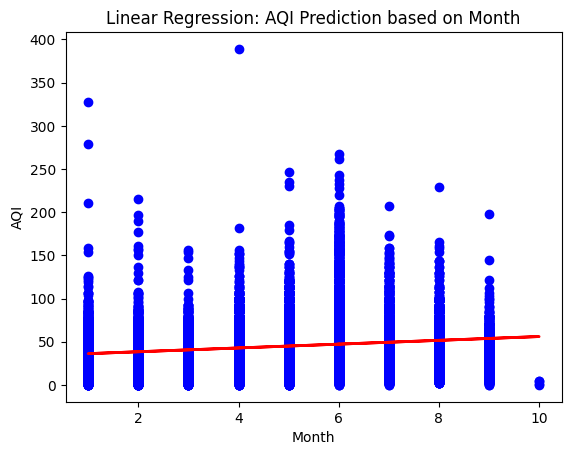

Mean Squared Error: 468.5426075856551


In [32]:
df['Date'] = pd.to_datetime(df['Date'])

# Derive a new feature 'Month' from the date
df['Month'] = df['Date'].dt.month

# Selecting only the 'Month' column as predictor
X = df[['Month']]
y = df['AQI']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Create and train the linear regression model
regressor = LinearRegression()
regressor.fit(X_train, y_train)

# Make predictions
y_pred = regressor.predict(X_test)

# Visualize the regression line
plt.scatter(X_test, y_test, color='blue')
plt.plot(X_test, y_pred, color='red', linewidth=2)
plt.xlabel('Month')
plt.ylabel('AQI')
plt.title('Linear Regression: AQI Prediction based on Month')
plt.show()

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

## Make a prediction

➡️ Assignment Tasks
- What would you predict the average AQI to be in the month of January?  

In [33]:
january_dates = pd.date_range(start='2023-01-01', end='2023-01-31')
january_df = pd.DataFrame({'Date': january_dates})

# Derive the 'Month' feature for January dates
january_df['Month'] = january_df['Date'].dt.month

# Predict AQI for January dates
january_df['Predicted_AQI'] = regressor.predict(january_df[['Month']])

# Calculate the average predicted AQI for January
average_aqi_january = january_df['Predicted_AQI'].mean()
print(f"Average predicted AQI for January: {average_aqi_january}")

Average predicted AQI for January: 36.20783284318919


## OPTIONAL: Compare Air Quality

➡️ Assignment Tasks
- Download the data from a year 20 years prior, using this website: https://aqs.epa.gov/aqsweb/airdata/download_files.html#AQI
- Append the new data to the previous dataframe
- Use the year as a variable in your regression.  Is year a significant factor in predicting AQI?

In [34]:
#import, append and create new model